# Azure Anomaly Detection 

Sample notebook showcasing Azures AD feature on GA pageview data.

Paste in API keys, and endpoints. Both are provided in the Azure Portal.

In [410]:
subscription_key = '864ca0a3c140497d860a98a94526c98f' 
endpoint = 'https://westeurope.api.cognitive.microsoft.com/anomalydetector/v1.0/timeseries/entire/detect'

## Import and transform

In [429]:
import requests
import json
import pandas as pd
import numpy as np
import csv  
import json  
import pytz
from datetime import timezone, datetime
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

In [434]:
from bokeh.plotting import figure,output_notebook, show
from bokeh.palettes import Blues4
from bokeh.models import ColumnDataSource,Slider
import datetime
from bokeh.io import push_notebook
from dateutil import parser
from ipywidgets import interact, widgets, fixed
output_notebook()

Loading BokehJS ...

Import standard GA pageview data from csv:

In [325]:
csv_data = pd.read_csv('tempdata - gR77S8JbQOy0KGdWud66Dw.csv')

Change the dateformat to comply with AAD API format:

In [326]:
csv_data['date'] = pd.to_datetime(csv_data['date'], format='%Y%m%d', errors='coerce')
csv_data['date'] = csv_data['date'].astype(str) + 'T00:00:00Z'

Sort and change type:

In [330]:
csv_data.sort_values(by=['date'], inplace=True)
csv_data['pageviews'] = csv_data['pageviews'].astype(int)

Rename and reset index:

In [332]:
csv_data.rename(index=str, columns={'date' : 'timestamp', 'pageviews' : 'value'}, inplace=True)
csv_data.reset_index(inplace=True)
csv_data.drop('index', axis=1, inplace=True)

## Load JSON

The API only takes JSON, and below is a hackish export/import solution

In [361]:
csv_data.to_json(r'sampledata.json', orient='records')

### Non-working solution

In [473]:
# js_ad = json.load(open('sampledata.json')); js_ad

In [344]:
with open(r"sampledata.json", "w") as f:
    f.write("{\"granularity\": \"daily\", \"series\": " + js_ad)

TypeError: must be str, not list

### "Class"-based solution

Hasn't been wrapped in a function yet, but below works.

Append prefix with granularity and series:

In [388]:
with open(r"sampledata.json", "r") as f:
    jsonfile = f.read()
with open(r"sampledata.json", "w") as f:
    f.write("{\"granularity\": \"daily\", \"series\": " + jsonfile)

In [390]:
with open(r"sampledata.json", "w+") as f:
    f.write(jsonfile + "}")
with open(r"sampledata.json", "r+") as f:
    jsonfile = f.read()

Inspect the datastructure:

In [472]:
# json.load(open("sampledata.json"))

## Detection

Define API request:

In [450]:
def send_request(endpoint, subscription_key, request_data):
    headers = {'Content-Type': 'application/json', 'Ocp-Apim-Subscription-Key': subscription_key}
    response = requests.post(endpoint, data=json.dumps(request_data), headers=headers)
    return json.loads(response.content.decode("utf-8"))

Batch-detection function:

In [453]:
def detect_batch(request_data):
    print("Detecting anomalies as a batch")
    result = send_request(endpoint, subscription_key, request_data)
    print(json.dumps(result, indent=4))

    if result.get('code') != None:
        print("Detection failed. ErrorCode:{}, ErrorMessage:{}".format(result['code'], result['message']))
    else:
        anomalies = result["isAnomaly"]
        print("Anomalies detected in the following data positions:")
        for x in range(len(anomalies)):
            if anomalies[x] == True:
                print (x)

Calling the API with the sample data from previous section:

In [470]:
# detect_batch(json_data)

## Plotting

Below is an end-end proposal 

In [468]:
def build_figure(sample_data, sensitivity):
    sample_data['sensitivity'] = sensitivity
    result = detect(endpoint, subscription_key, sample_data)
    columns = {'expectedValues': result['expectedValues'], 'isAnomaly': result['isAnomaly'], 'isNegativeAnomaly': result['isNegativeAnomaly'],
          'isPositiveAnomaly': result['isPositiveAnomaly'], 'upperMargins': result['upperMargins'], 'lowerMargins': result['lowerMargins'],
          'timestamp': [parser.parse(x['timestamp']) for x in sample_data['series']], 
          'value': [x['value'] for x in sample_data['series']]}
    response = pd.DataFrame(data=columns)
    values = response['value']
    label = response['timestamp']
    anomalies = []
    anomaly_labels = []
    index = 0
    anomaly_indexes = []
    p = figure(x_axis_type='datetime', title="Batch Anomaly Detection ({0} Sensitvity)".format(sensitivity), width=800, height=600)
    for anom in response['isAnomaly']:
        if anom == True and (values[index] > response.iloc[index]['expectedValues'] + response.iloc[index]['upperMargins'] or 
                         values[index] < response.iloc[index]['expectedValues'] - response.iloc[index]['lowerMargins']):
            anomalies.append(values[index])
            anomaly_labels.append(label[index])
            anomaly_indexes.append(index)
        index = index+1
    upperband = response['expectedValues'] + response['upperMargins']
    lowerband = response['expectedValues'] -response['lowerMargins']
    band_x = np.append(label, label[::-1])
        #band_x = np.append(label, label[::-1])
    band_y = np.append(lowerband, upperband[::-1])
        #band_y = np.append(lowerband, upperband[::-1])
    boundary = p.patch(band_x, band_y, color=Blues4[2], fill_alpha=0.5, line_width=1, legend='Boundary')
    p.line(label, values, legend='Value', color="#2222aa", line_width=1)
    p.line(label, response['expectedValues'], legend='ExpectedValue',  line_width=1, line_dash="dotdash", line_color='olivedrab')
    anom_source = ColumnDataSource(dict(x=anomaly_labels, y=anomalies))
    anoms = p.circle('x', 'y', size=5, color='tomato', source=anom_source)
    p.legend.border_line_width = 1
    p.legend.background_fill_alpha  = 0.1
    show(p, notebook_handle=True)

In [465]:
sample_data = json.load(open('sampledata.json'))
sample_data['granularity'] = 'daily'

## Interactive plot

In [469]:
# 95 sensitivity
build_figure(sample_data,80)

### One week lookback

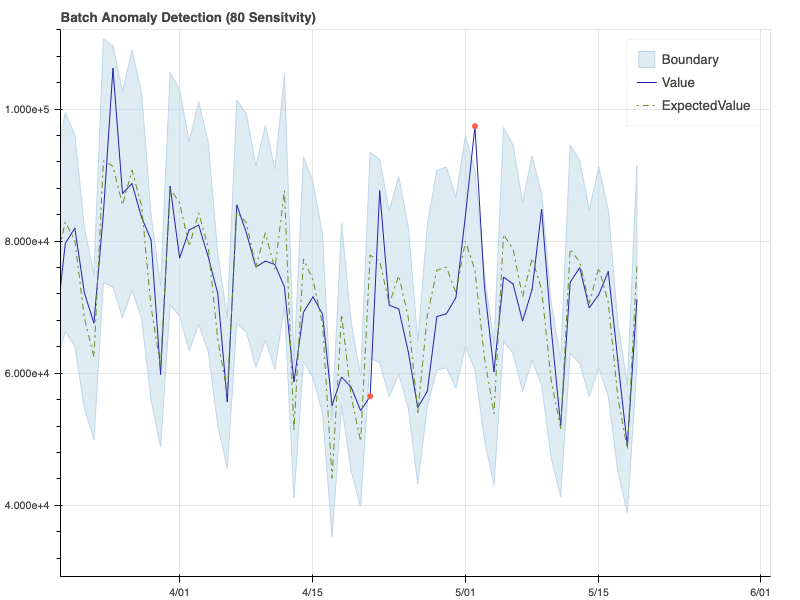

In [467]:
Image("bokeh_plot (3).png")

### Entire dataset: 95 conf

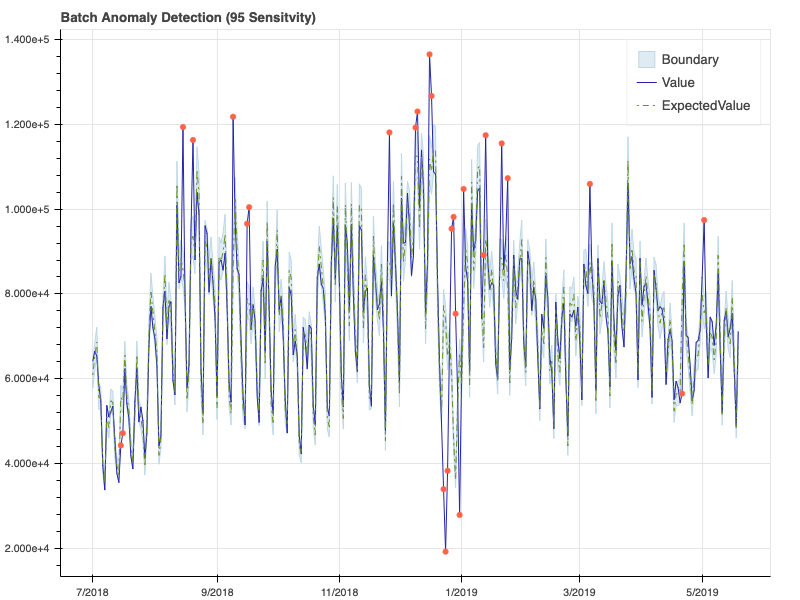

In [460]:
from IPython.display import Image
Image("bokeh_plot.png")

### Entire dataset: 80 percent conf

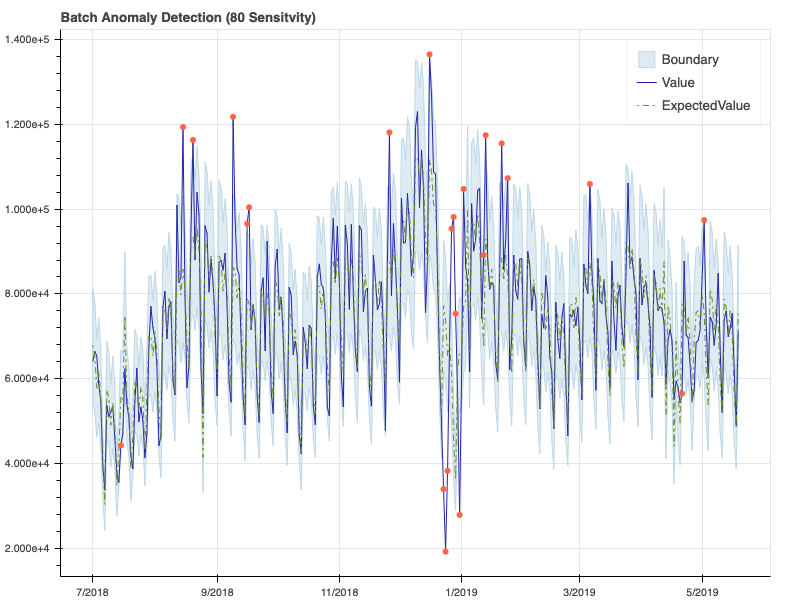

In [458]:
from IPython.display import Image
Image("bokeh_plot (1).png")